## Imports

In [1]:
from madgwickahrs import * 
from quaternion import Quaternion
from conversion import * 
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.stats import norm
from numpy import linalg as LA
from numpy.linalg import inv
import time
from IPython.display import Image as ImageDisp
from sympy import Symbol, symbols, Matrix, sin, cos, latex#, Plot
from sympy.interactive import printing
printing.init_printing()
%pylab inline --no-import-all


Populating the interactive namespace from numpy and matplotlib


In [2]:
dt = 0.025

# Purely Translational Motion - constant velocity

## Read Files

In [4]:
trajectory_file = open("/Users/eunsunlee/Documents/NESL/UnderwaterSensorTag/IMU_GPS_Fusion/Trajectory_Simulation/simulated_measurement_from_imusim/puretranslation_test_trajectory_from_imusim.txt",'r')

time = []
px = []
py = []
pz = []
vx = []
vy = []
vz = []
Ax = []
Ay = []
Az = []
 
for i in trajectory_file:
    sp = i.split()
    time.append(float(sp[0]))
    px.append(float(sp[1]))
    py.append(float(sp[2]))
    pz.append(float(sp[3]))
    vx.append(float(sp[4]))
    vy.append(float(sp[5]))
    vz.append(float(sp[6]))
    Ax.append(float(sp[7]))
    Ay.append(float(sp[8]))
    Az.append(float(sp[9]))

    
trajectory_file.close()
print(len(time))

imu_values_file = open("/Users/eunsunlee/Documents/NESL/UnderwaterSensorTag/IMU_GPS_Fusion/Trajectory_Simulation/simulated_measurement_from_imusim/puretranslation_test_imu_values_from_imusim.txt",'r')

ax = []
ay = []
az = []
gx = []
gy = []
gz = []
magx = []
magy = []
magz = []

for i in imu_values_file: 
    sp = i.split()
    ax.append(float(sp[1]))
    ay.append(float(sp[2]))
    az.append(float(sp[3]))
    gx.append(float(sp[4]))
    gy.append(float(sp[5]))
    gz.append(float(sp[6]))
    magx.append(float(sp[7]))
    magy.append(float(sp[8]))
    magz.append(float(sp[9]))
    
imu_values_file.close()

368


## Visualize the trajectory from ground truth position measurement 
-  px, py, pz
-  Please note that it is equal to the trajectory in blender but depends on short_len


No handles with labels found to put in legend.


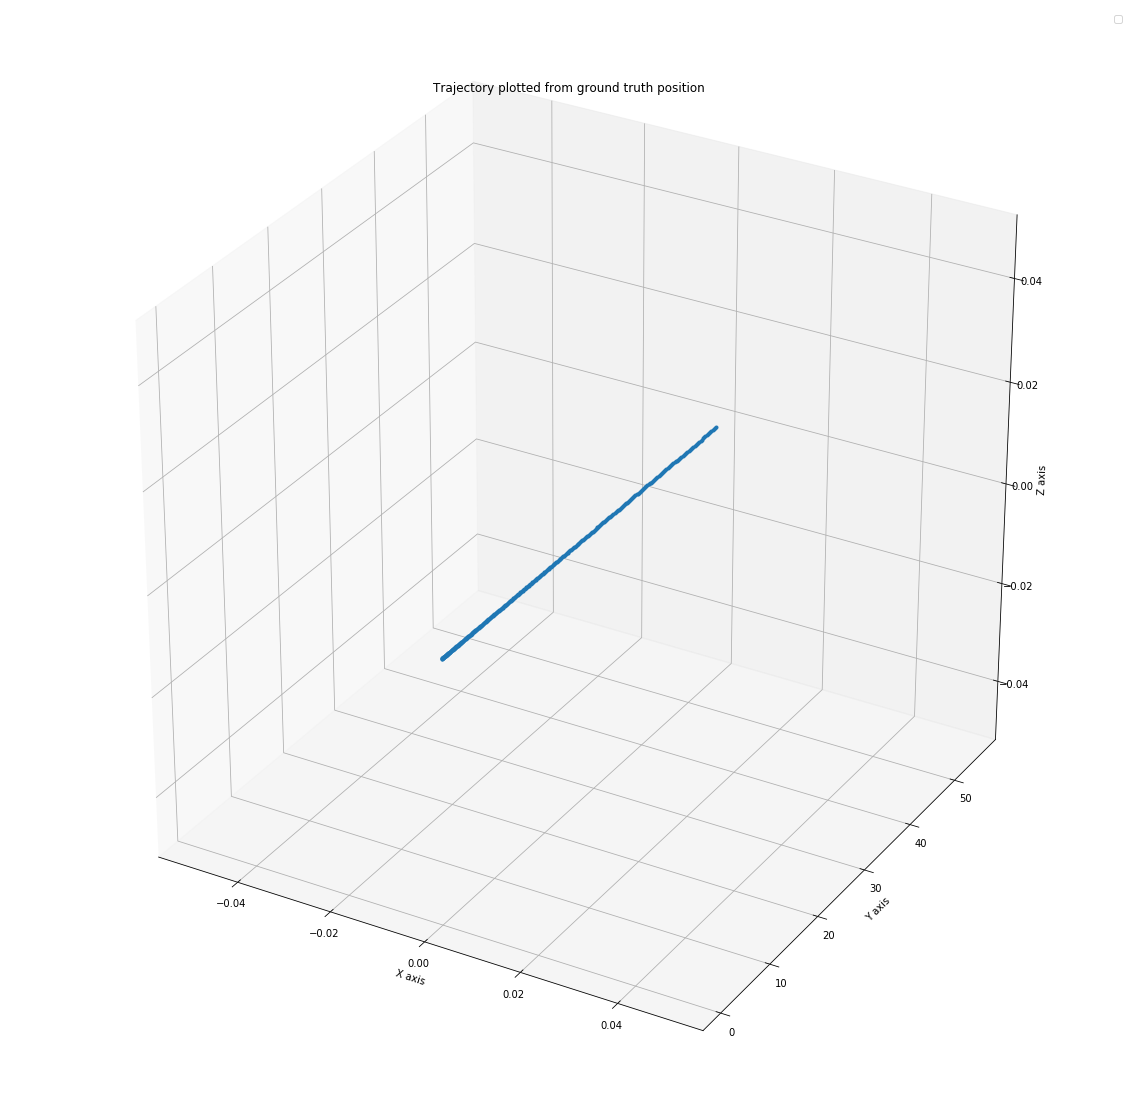

In [5]:
fig = plt.figure(figsize=(20,20))
axplot = fig.gca(projection='3d')
axplot.set_title("Trajectory plotted from ground truth position")
axplot.plot(px, py, pz, '.')
axplot.legend()
axplot.set_xlabel('X axis')
axplot.set_ylabel('Y axis')
axplot.set_zlabel('Z axis')
plt.show()

## Generate Ax, Ay, Az from ground truth IMU measurement
- This step is to verify the conept
- Ax, Ay, Az can be calculated from ax, ay, az if orientaion is given
- Initial orientation is necessary to calculate the following orientation from gyroscope
- yaw, pitch roll of an object at time[0] = ?

#### First, visualize the difference between acceleration in body frame and world frame

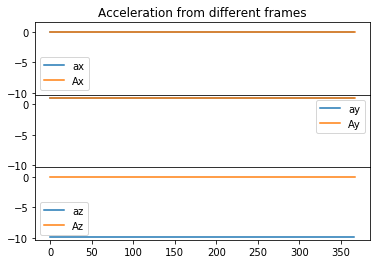

In [9]:
# Acceleration from different frames
fig, (axplot1, axplot2, axplot3) = plt.subplots(3, sharex=True, sharey=True)
axplot1.plot(ax, label='ax')
axplot1.plot(Ax, label='Ax')
axplot1.set_title('Acceleration from different frames')
axplot1.legend()
axplot2.plot(ay, label='ay')
axplot2.plot(Ay, label='Ay')
axplot2.legend()
axplot3.plot(az, label='az')
axplot3.plot(Az, label='Az')
# axplot3.plot(np.array(Ax)-9.8, label='Az with g ')
axplot3.legend()
fig.subplots_adjust(hspace=0)


#### Functions needed to calculate initial orientation

In [7]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def find_R(V1, V2):
    v1_u = unit_vector(V1)
    v2_u = unit_vector(V2)
    V = np.cross(v1_u, v2_u)
    s = LA.norm(np.cross(v1_u, v2_u))
    c = np.dot(v1_u, v2_u)

    I = np.mat([[1,0,0],[0,1,0],[0,0,1]])
    v1 = V[0]
    v2 = V[1]
    v3 = V[2]
    Vx = np.mat([[0,-v3,v2],[v3,0,-v1],[-v2,v1,0]])
    R = I + Vx + (Vx**2)*((1-c)/s**2)
    return R



In [15]:
Azg = np.array(Ax) - 9.8

v1 = [ax[0], ay[0], az[0]]
v2 = [Ax[0], Ay[0], Azg[0]]
print(v1)
print(v2)

R = find_R(v1, v2)
print(R)

[0.0, 1.0, -9.81]
[0.0, 1.0, -9.8]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.99999995e-01 -1.02946323e-04]
 [ 0.00000000e+00  1.02946323e-04  9.99999995e-01]]


In this purely rotational motion, gyroscope is experiencing:  0.0 rad/s
0.0
0.016013395785624503


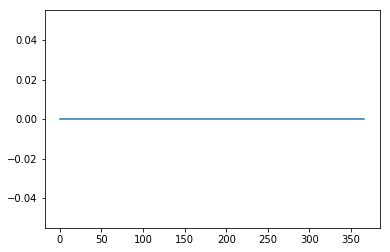

In [8]:
# First, calculate Rotational matrix between a and A 
from a3muse import IntegrationRK4, QuatToRotMat, quatNormalized, AccMagOrientation, QuatToEuler
from quaternionClass import QuaternionClass


print("In this purely rotational motion, gyroscope is experiencing: ", gz[0], "rad/s")

quat = QuaternionClass(1, 0, 0, 0)
omega0 = [gx[0], gy[0], gz[0]]
# omega0 = [0,0,0]
total_yaw = 0
qz = []
for i in range(len(gx)):
    omega1 = [gx[0], gy[0], gz[0]] 
#     omega1 = [0,0,0] 
    quatG = IntegrationRK4(omega0, omega1, quat, dt)
#     print(quatG[0], quatG[1], quatG[2], quatG[3])
    yaw,pitch,roll = QuatToEuler(quatG)
    total_yaw += yaw
    quat = quatG
    qz.append(quat[3])
#     print(yaw)
    omega0 = omega1

# 0.00174532924094 rad/s 
print(yaw)
print(0.00174532924094*dt*len(gz))
plt.plot(qz)
